# Importamos bibliotecas necesarias

In [47]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [48]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [49]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [50]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [51]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [52]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [53]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

# Leer el data set desde el archivo csv

In [54]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [55]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [56]:
df['state_name'].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Santiago Del Estero', 'Jujuy'],
      dtype=object)

In [57]:

filtroParaElSubsetDeDatos = ['Santa Cruz', 'Río Negro', 'Neuquén', 'Tierra del Fuergo', 'Chubut']

In [58]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403 entries, 166 to 108628
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              1403 non-null   object 
 1   place_name                 1403 non-null   object 
 2   price                      1403 non-null   float64
 3   surface_covered_in_m2      1403 non-null   float64
 4   surface_not_covered_in_m2  1403 non-null   float64
 5   price_usd_per_m2           1403 non-null   float64
 6   rooms                      1403 non-null   float64
 7   lat_mediaPorZona           1403 non-null   float64
 8   lon_mediaPorZona           1403 non-null   float64
 9   pileta                     1403 non-null   int64  
 10  cochera                    1403 non-null   int64  
 11  balcon                     1403 non-null   int64  
 12  terraza                    1403 non-null   int64  
 13  parrilla             

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

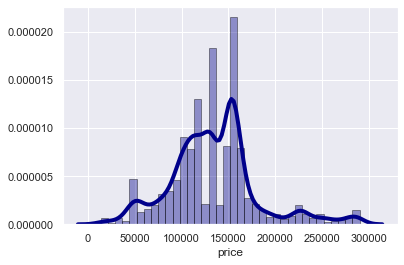

In [59]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


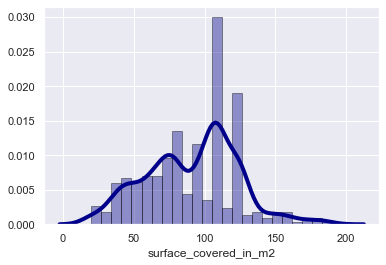

In [60]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

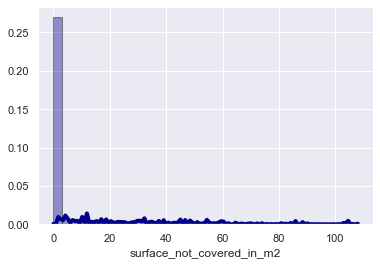

In [61]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

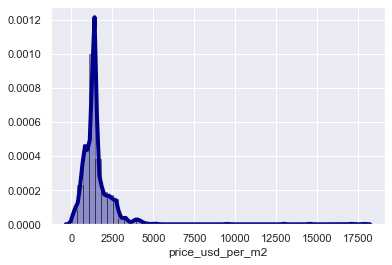

In [62]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

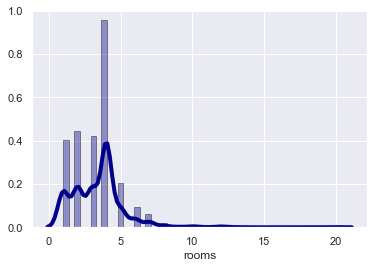

In [63]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [64]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000
mean,134113.357961,91.220594,7.006727,1511.290962,3.377049,-40.436799,-69.704381,0.035638,0.294369,0.077691,0.096935,0.107627
std,46758.510706,32.415413,17.779829,1072.222740,1.751612,1.557795,2.036335,0.185452,0.455921,0.267780,0.295975,0.310019
min,13500.000000,20.000000,0.000000,13.500000,1.000000,-51.623049,-71.645524,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109956.028571,68.353771,0.000000,1037.321024,2.000000,-41.132599,-71.346118,0.000000,0.000000,0.000000,0.000000,0.000000
50%,130942.051974,97.066667,0.000000,1398.550725,4.000000,-41.132599,-71.327997,0.000000,0.000000,0.000000,0.000000,0.000000
75%,153691.176471,108.987013,0.000000,1678.681903,4.000000,-38.952197,-68.088963,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,108.000000,17857.142857,20.000000,-31.561325,-62.994632,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 3000)

In [66]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 8)

In [67]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              1267 non-null   object 
 1   place_name                 1267 non-null   object 
 2   price                      1267 non-null   float64
 3   surface_covered_in_m2      1267 non-null   float64
 4   surface_not_covered_in_m2  1267 non-null   float64
 5   price_usd_per_m2           1267 non-null   float64
 6   rooms                      1267 non-null   float64
 7   lat_mediaPorZona           1267 non-null   float64
 8   lon_mediaPorZona           1267 non-null   float64
 9   pileta                     1267 non-null   int64  
 10  cochera                    1267 non-null   int64  
 11  balcon                     1267 non-null   int64  
 12  terraza                    1267 non-null   int64  
 13  parrilla                   1267 non-null   int64

# Analizamos las variables categóricas

san carlos de bariloche    547
confluencia                168
neuquén                    142
general roca                90
lácar                       52
san martín de los andes     50
villa la angostura          34
trelew                      27
cipolletti                  25
chubut                      17
puerto madryn               14
esquel                      12
caleta olivia               11
comodoro rivadavia          10
viedma                       9
plottier                     7
centenario                   7
rincón de los sauces         6
río negro                    6
trevelín                     6
rada tilly                   5
junin de los andes           5
rawson                       4
las grutas                   3
general fernández oro        3
choele choel                 3
luis beltrán                 1
aluminé                      1
cinco saltos                 1
cañadón seco                 1
Name: place_name, dtype: int64


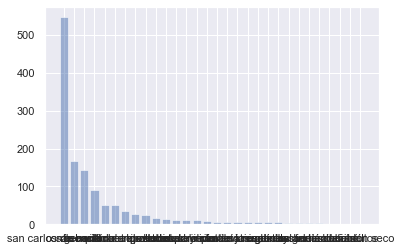

house        605
apartment    478
PH           104
store         80
Name: property_type, dtype: int64


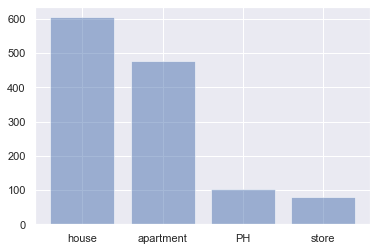

In [68]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [69]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [70]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura,property_type_apartment,property_type_house,property_type_store
0,apartment,confluencia,82664.530000,57.000000,20.5,1066.639097,1.0,-38.952197,-68.088963,0,...,0,0,0,0,0,0,0,1,0,0
1,apartment,confluencia,113984.891364,77.500000,0.0,1470.772792,1.0,-38.952197,-68.088963,0,...,0,0,0,0,0,0,0,1,0,0
2,apartment,general roca,51509.900657,82.000000,0.0,628.169520,1.0,-38.945588,-67.780159,0,...,0,0,0,0,0,0,0,1,0,0
3,PH,san martín de los andes,130833.333333,75.000000,60.0,969.135802,4.0,-40.144756,-71.327997,0,...,0,0,1,0,0,0,0,0,0,0
4,house,viedma,240000.000000,108.987013,0.0,2202.097235,4.0,-40.814045,-62.994632,0,...,0,0,0,0,0,1,0,0,1,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [71]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_caleta olivia,place_name_cañadón seco,place_name_centenario,place_name_choele choel,place_name_chubut,place_name_cinco saltos,place_name_cipolletti,place_name_comodoro rivadavia,place_name_confluencia,...,place_name_rada tilly,place_name_rawson,place_name_rincón de los sauces,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura
0,confluencia,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,general roca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,san martín de los andes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,viedma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,neuquén,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,san carlos de bariloche,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14,trelew,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15,rada tilly,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16,lácar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,cipolletti,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [72]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,apartment,1,0,0
3,PH,0,0,0
4,house,0,1,0
68,store,0,0,1


# Generamos el objeto para el K Fold

In [73]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [74]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura,property_type_apartment,property_type_house,property_type_store
0,57.000000,20.5,1066.639097,1.0,-38.952197,-68.088963,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,77.500000,0.0,1470.772792,1.0,-38.952197,-68.088963,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,82.000000,0.0,628.169520,1.0,-38.945588,-67.780159,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,75.000000,60.0,969.135802,4.0,-40.144756,-71.327997,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,108.987013,0.0,2202.097235,4.0,-40.814045,-62.994632,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,97.625000,0.0,880.921895,2.0,-38.940071,-68.185935,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1263,123.875000,0.0,818.076217,7.0,-38.952197,-68.088963,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1264,97.066667,0.0,1348.990920,2.0,-41.132599,-71.346118,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1265,97.625000,0.0,2868.117798,6.0,-38.940071,-68.185935,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Generamos un modelo con Regresion Lineal

In [75]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [76]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [77]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-3.59060473e+24 -7.49777702e+25 -1.93173438e+27 -4.42907791e+27
  4.22374596e-01]



Intercept: 
1434.116912294071



Coeficientes: 
[-2.59334305e+02 -1.83110184e+02 -7.09089733e+00 -3.48106121e+15
  2.37435138e+14  3.41908351e+01  2.01985266e+01  5.99575835e+00
  3.05955264e+01 -1.91519724e+01 -1.52118191e+15 -5.03758769e+14
 -3.82211093e+12 -7.52464939e+13 -1.09967029e+15 -2.97061719e+12
 -5.03255131e+13 -1.37118035e+15 -1.31717185e+14 -8.81531148e+14
 -1.13797329e+13 -1.04976094e+14 -1.39482617e+14 -2.43550546e+14
 -4.19116693e+13 -5.62870332e+14 -1.09769695e+14 -2.87647661e+13
 -9.95233598e+14 -1.03395116e+15  9.34194207e+14  2.26123594e+14
 -3.01996673e+14 -2.47289235e+15 -5.35083547e+14 -1.50772485e+15
 -6.52250166e+14 -4.17507862e+14 -6.58339958e+14 -8.95888679e+01
 -3.89838443e+01  1.58979207e+01]



MAE: 445.4576631745544
MSE: 363854.47559731494
RMSE: 603.2035109292012
R2: -1.6386913264417058


In [78]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
7,1223.193884,1412.052327,-188.858443
782,1415.314336,1420.340912,-5.026576
305,611.204521,968.340912,-357.136391
1052,776.543154,985.965912,-209.422758
217,599.964884,2262.052327,-1662.087444
420,901.287554,1659.892131,-758.604577
1166,1290.322581,1804.340912,-514.018331
261,1037.321024,847.840912,189.480112
1094,1132.075472,1441.340912,-309.265440
643,920.411641,1339.552327,-419.140686


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [79]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [80]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: [0.37906603 0.39005553 0.50662127 0.44302987 0.32338467]
Alpha Ridge CV: 10.0
Coeficientes:  [-232.71398239 -161.81827034   -4.55610789   -9.42606643  -57.0785207
   26.10321427   12.77526964    8.48509353   32.30328985  -17.8214702
  -36.88498917    2.05267251   17.54705958    7.44663873  -66.14189036
    1.33546372  -10.52451082   17.22527275  -47.31584414   31.48728207
   -1.76624762 -118.11362375  -16.75442607   44.41477713  -11.38770474
   -8.59448397  119.95821368  -31.5317664    30.31591473   33.36594501
    3.0870229   -54.12298497   -3.15687203   -4.65742502   65.95047575
  -22.38954656  -14.52537331   -7.98092644   91.64719316  -77.45950708
  -17.66602536   22.87139541]
MAE: 272.4298514402688
MSE: 161098.93040632192
RMSE: 401.371312385828
R2: 0.44335019288087785


In [81]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
7,1223.193884,1500.601847,-277.407963
782,1415.314336,1423.773508,-8.459172
305,611.204521,1030.887608,-419.683087
1052,776.543154,971.043172,-194.500018
217,599.964884,2037.974033,-1438.009149
...,...,...,...
840,1716.417910,1726.004654,-9.586743
213,1348.990920,1392.585815,-43.594895
1062,1666.666667,1150.947981,515.718686
255,1866.651000,1550.803399,315.847601


# Generamos el modelo para Lasso Cross Validation

In [82]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1423.575282256349



Coeficientes: 



[-225.00519639 -153.72652098   -1.7097792    -0.          -73.33906067
   16.81209452    6.29881649    0.88971715   22.76758547   -9.55002032
  -22.88292429    0.           12.62047129    3.50955677  -52.05203089
    0.           -0.35069281   16.93609621  -30.4593904    28.02303146
    0.         -104.24147137  -10.2075017    42.58711837   -3.63181438
   -1.07822174  130.17622528  -20.99614828   33.83856897   31.99128802
    0.          -47.38830406    0.            0.           63.58622568
   -5.31322772   -6.90529697   -0.           87.99023156  -48.95057613
   -0.           26.66959541]



MAE: 273.38315701755255
MSE: 164593.1441565826
RMSE: 405.70080620647354
R2: 0.431276534755341


In [83]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
7,1223.193884,1537.344985,-314.151101
782,1415.314336,1419.433772,-4.119437
305,611.204521,1064.140748,-452.936227
1052,776.543154,1014.983634,-238.440480
217,599.964884,1904.576345,-1304.611461
...,...,...,...
840,1716.417910,1709.801295,6.616616
213,1348.990920,1403.441747,-54.450827
1062,1666.666667,1128.183551,538.483116
255,1866.651000,1613.816658,252.834342


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [84]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-3.59060473e+24 -7.49777702e+25 -1.93173438e+27 -4.42907791e+27
  4.22374596e-01]
Score Train Ridge:  [0.37906603 0.39005553 0.50662127 0.44302987 0.32338467]
Score Train Lasso:  [0.39314596 0.36985154 0.51793007 0.4533442  0.32037204]


### Visualizamos los errores cuadraticos medios

In [85]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 603.2035109292012
Train RMSE RidgeCV: 401.371312385828
Train RMSE Lasso: 405.70080620647354


In [86]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: -1.6386913264417058
Train R2 RidgeCV: 0.44335019288087785
Train R2 Lasso: 0.431276534755341


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [87]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

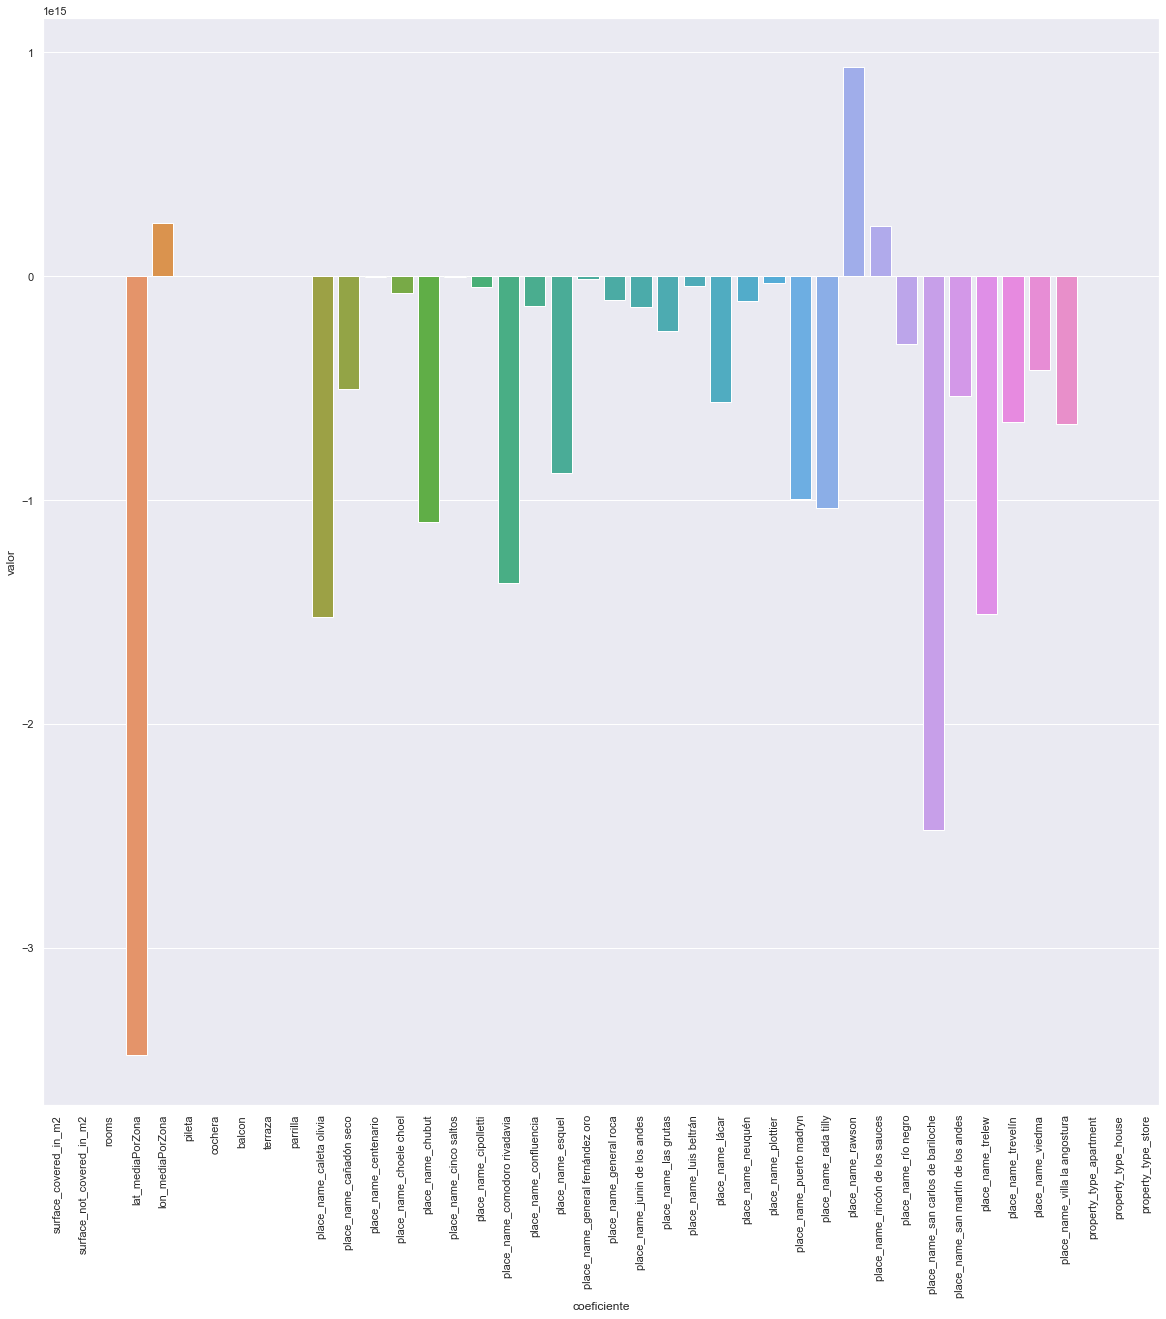

In [88]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [89]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

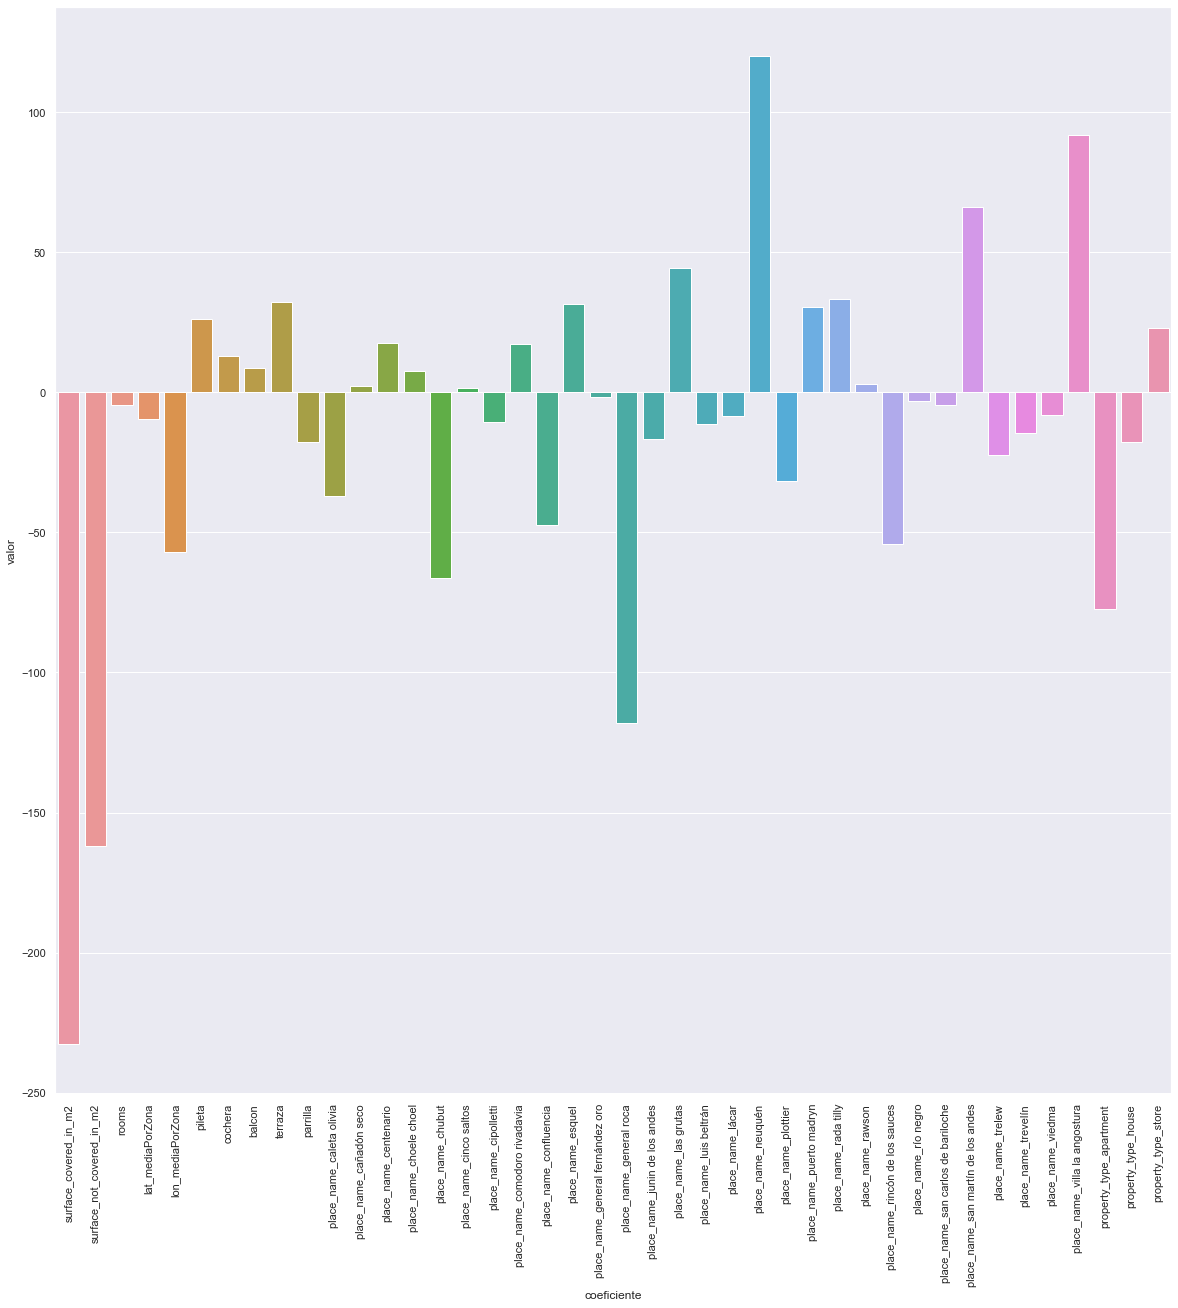

In [90]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [91]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

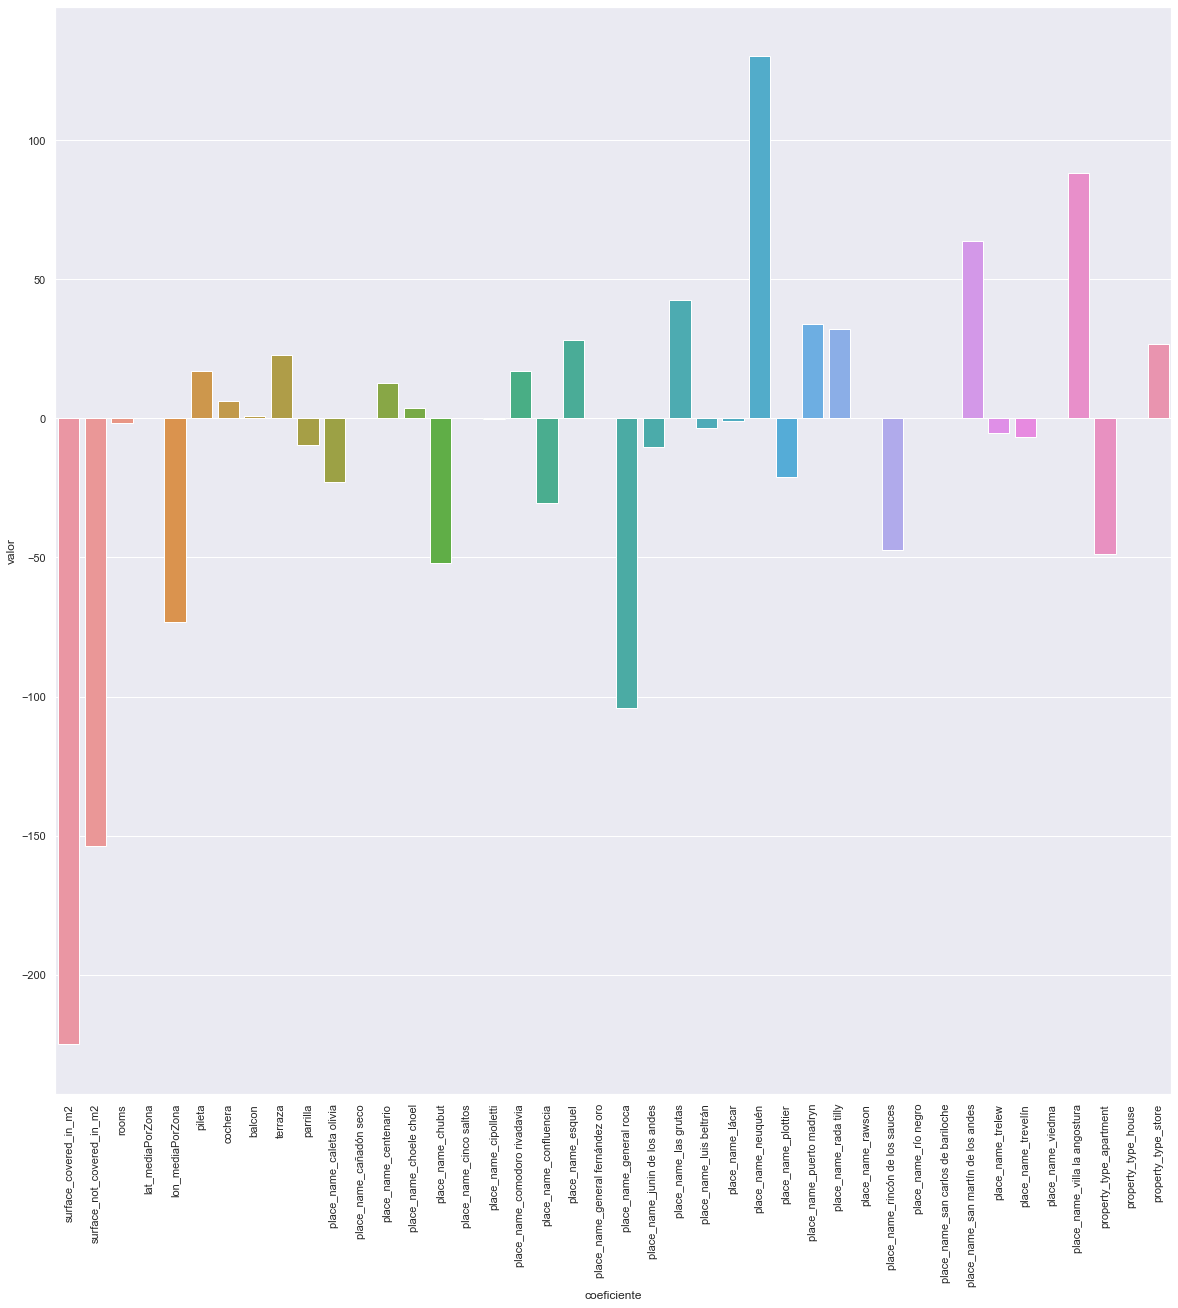

In [92]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20